In [1]:
%matplotlib inline

/opt/gypsy/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Run simulation

Advised to run this in terminal to get realtime progerss update

``` bash
# python -m cProfile -s cumtime  "$(which gypsy)" simulate ../private-data/1000-plots.csv_prepped.csv > profile_sim_1000.txt 
# don't profile, it's too slow on 1K plots. only need to profile on a couple with/without slow convergence
gypsy simulate ../private-data/1000-plots.csv_prepped.csv > profile_sim_1000.txt
```

Now with logs that indicate the time taken for each plot.

We should compile statistics related to time.

# Investigate time taken as relates to data

### Summary of influence of plot characteristics and duration distribution

This summary is based on the investigation below.

Long duration plots (which take > 10 seconds, the 90 percentile of duration) account for 32% of the total simulation time). Long duration plots are 5-7x slower.

Higher aspen density is associated with longer durations, determined by visual inspection of charts.

Base case optimizations also apply to the edge case - e.g. a reduction of 1 second in basecase probably applies to all cases.

In terms of optimizations, base cases are easier to optimize, e.g. we fetch a lot of data in separate statements instead of combining them into one statement.

Note also that plot 3185 takes 20 seconds but does not have the slow convergence issue - (or at least it is not logged), and only 10 plots are reported as having slow convergence (i.e. stop before tolerance is reached) while 100 take more than 10 seconds. So there are other causes to the slow plots.

Given these, we will likely receive a greater net benefit from targeting optimization of the base case.

Can skip from here to the next major section - identifying slow code.

### Use a regex to get plot id and time and join that to the result of running data prep

``` python
import re
import pandas as pd
from pandas.tools.plotting import scatter_matrix

plots_prepped = pd.read_csv('../private-data/1000-plots.csv_prepped.csv', index_col=0)
plots_prepped['PlotID'] = plots_prepped['PlotID'].astype(int)

pattern = '^.*plot (.*) took (.*) seconds$'
rec = re.compile(pattern)
```

``` python
matches = [rec.match(line) for line in open('gypsy.log', 'r') if rec.match(line) is not None]
times = [m.group(1,2) for m in matches]
times_df = pd.DataFrame(times, columns=['PlotID', 'duration'])
times_df['PlotID'] = times_df['PlotID'].astype(int)
times_df['duration'] = times_df['duration'].astype(float)
```

``` python
plots_times = pd.merge(plots_prepped, times_df, how='left', on='PlotID')
```

Remove degenerate variables

``` python
plots_times = plots_times.loc[:, plots_times.std()>1]
```

### Identify the slow cases

Overall:

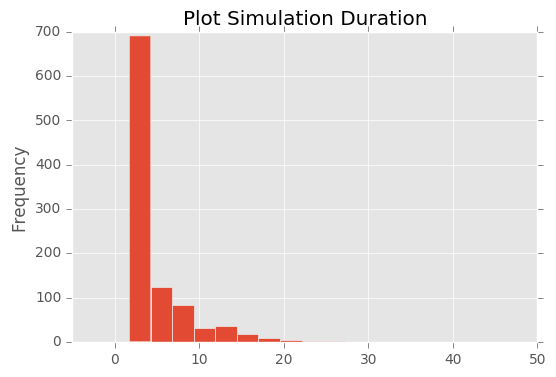

In [51]:
plots_times['duration'].plot(kind='hist', title='Plot Simulation Duration', xlim=(-5,50))

Looks exponential...

In [81]:
slow_cases = plots_times['duration'] > np.percentile(plots_times['duration'].values, 90)

In [96]:
plots_times['is_slow'] = slow_cases
plots_times['is_slow'] = plots_times['is_slow'].astype(object)

**'slow' cases account for 32% of the total time**

In [90]:
plots_times.loc[slow_cases, 'duration'].sum()/plots_times['duration'].sum()

0.32412375434658358

By variable:

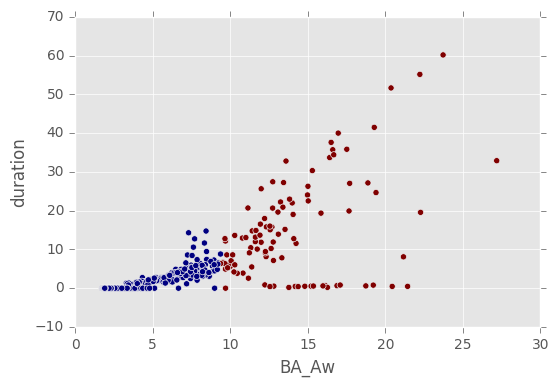

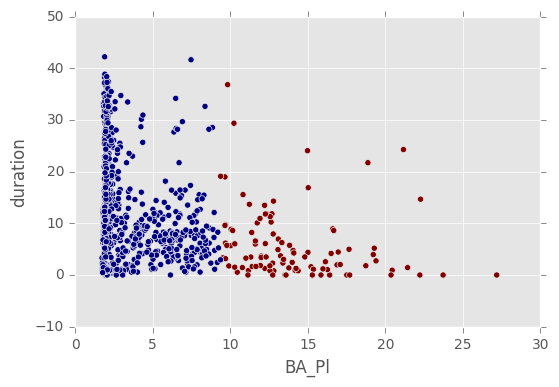

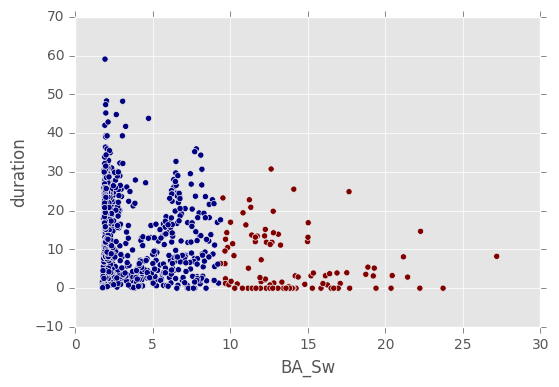

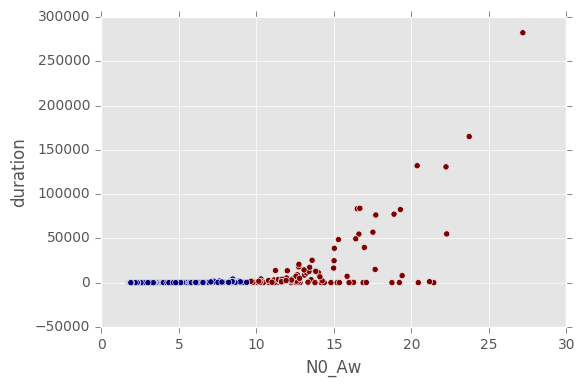

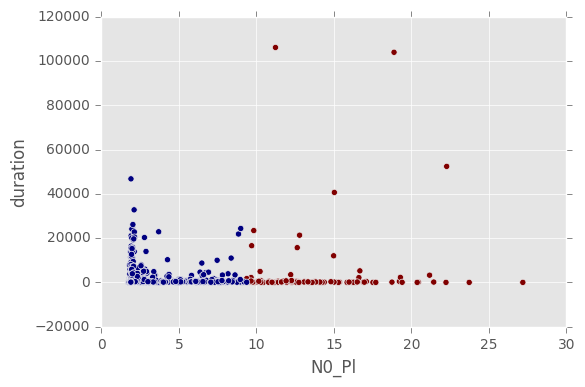

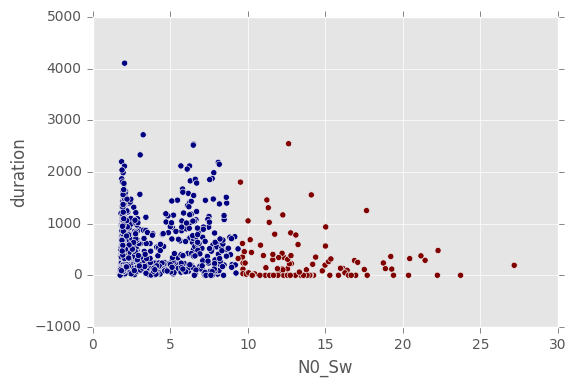

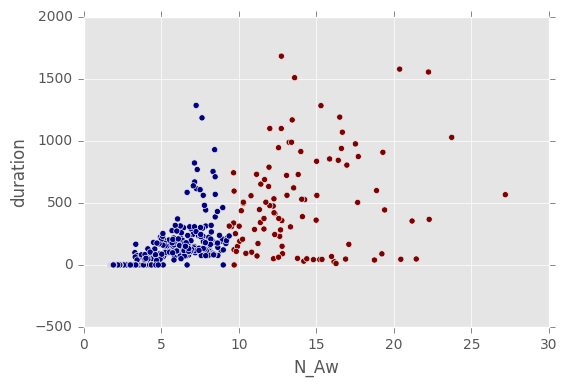

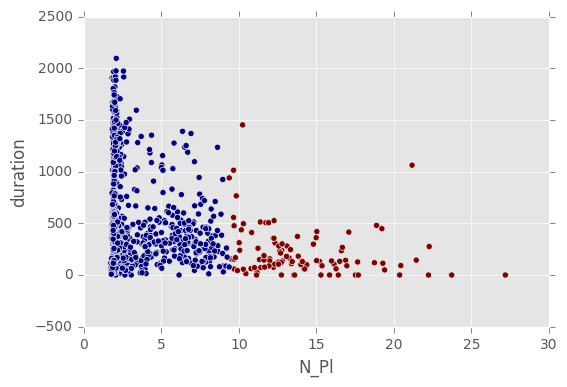

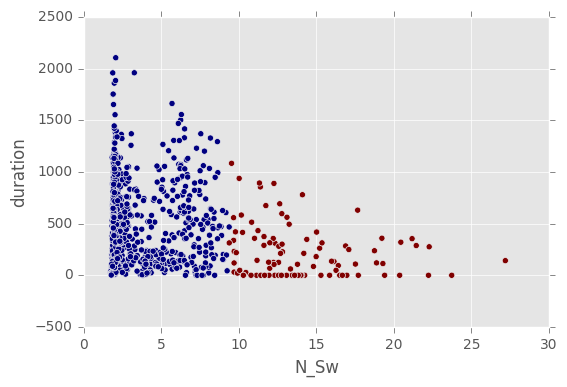

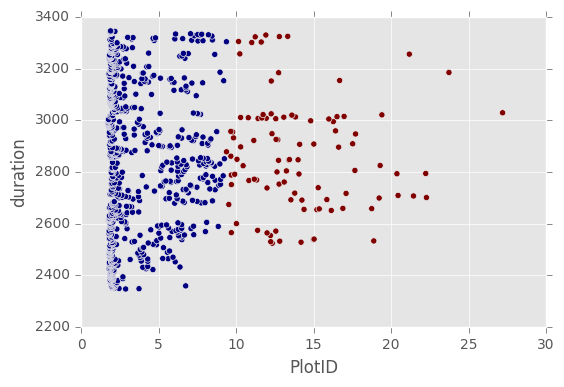

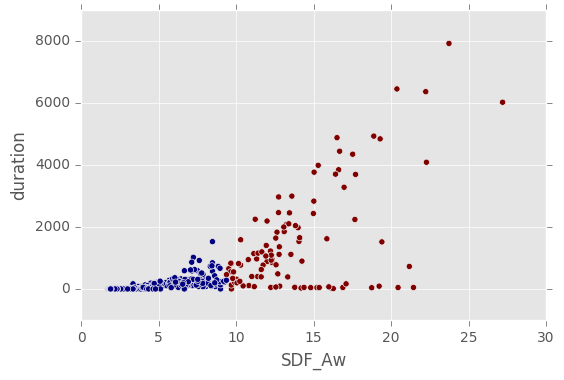

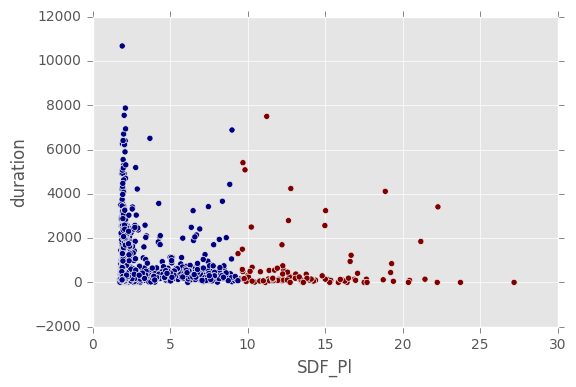

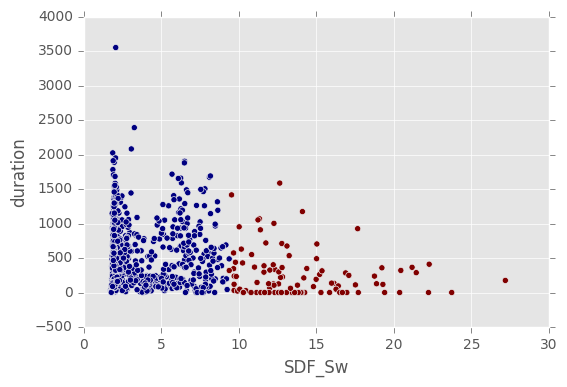

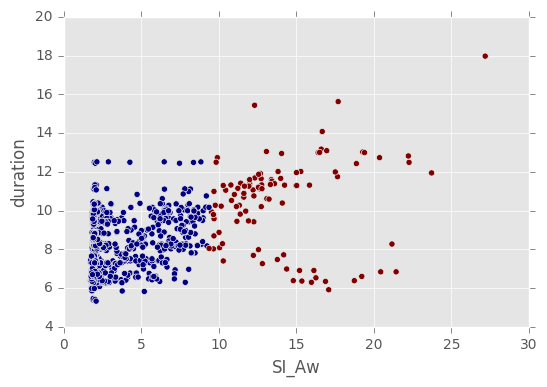

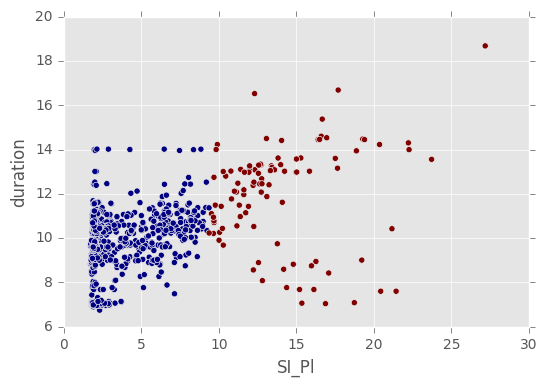

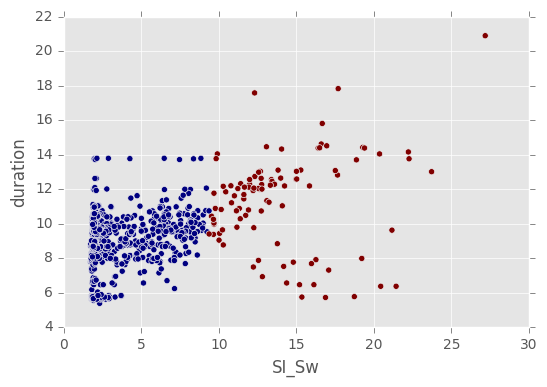

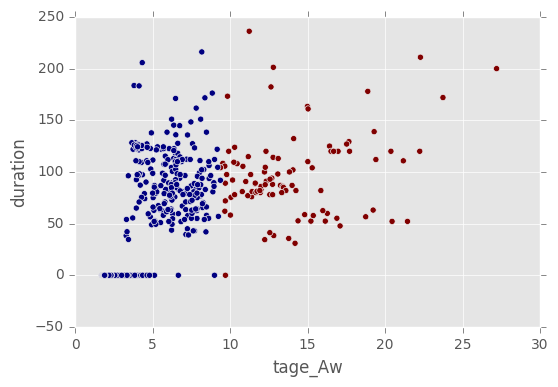

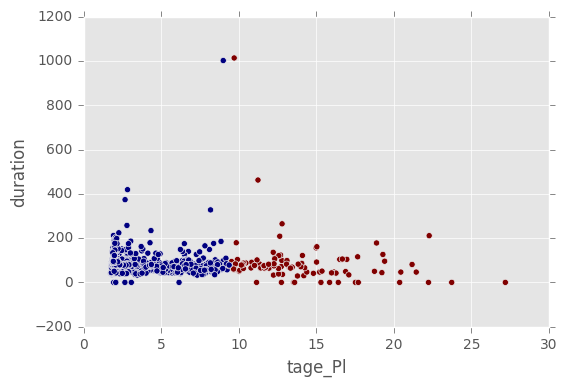

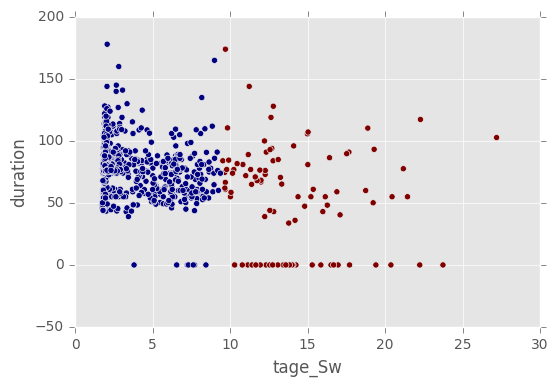

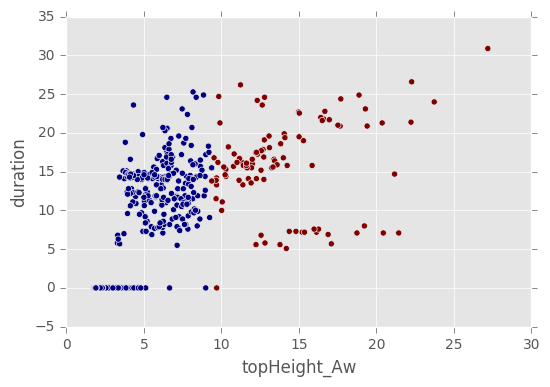

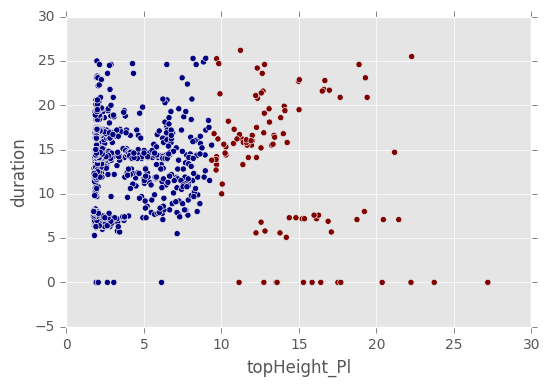

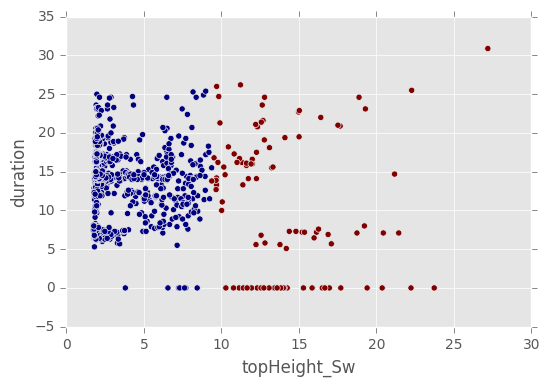

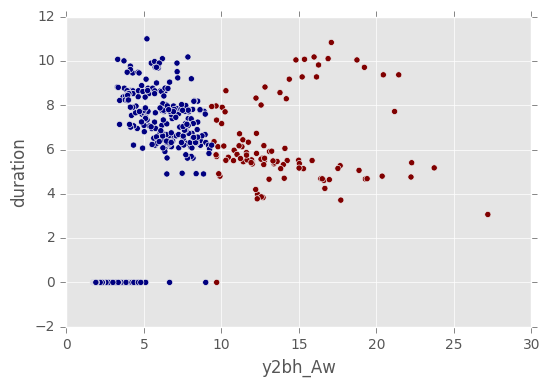

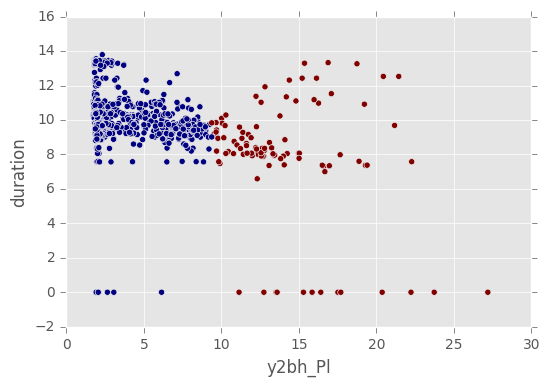

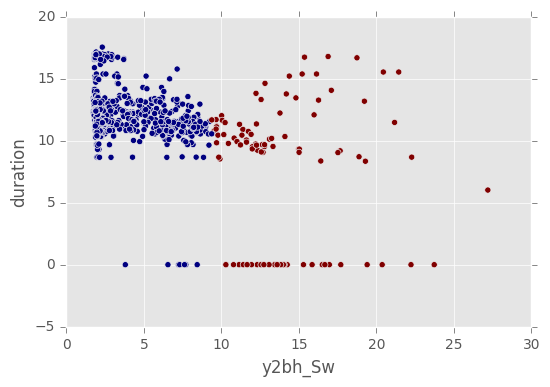

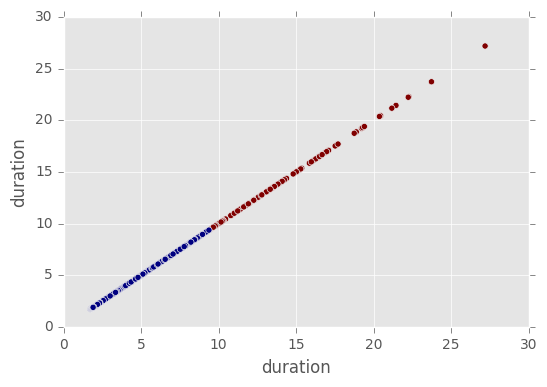

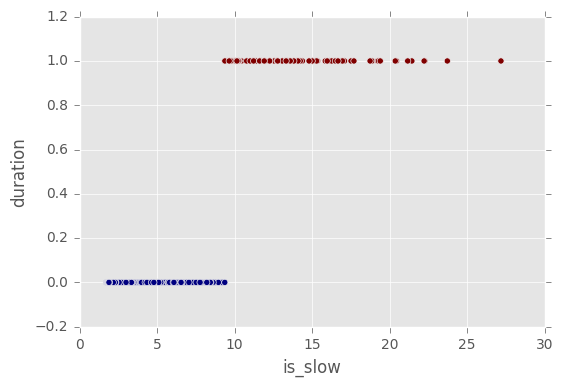

In [115]:
for col in plots_times.columns:
    plt.scatter(x=plots_times['duration'], y=plots_times[col], c=plots_times['is_slow'])
    plt.xlabel(col)
    plt.ylabel('duration')
    plt.show()
    # ax = 

** slow plots are faster when there's less aspen, slower when there's more aspen **

## Identify slow code

A first attempt towards this will use cprofile to run simulation on a random subset of the data.

This hasn't worked well because of the module loading/cli. In order to narrow in on gypsy, in another notebook (#32-isolated-profiling) I amn profiling simulate_forwards in isolation

### Visualize profiling

In [120]:
%%bash
pip install pyprof2calltree

  Running setup.py bdist_wheel for pyprof2calltree: started
  Running setup.py bdist_wheel for pyprof2calltree: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/3b/1a/6b/74748a90d412cf3f774929b45d645b6d5b9a56bd6e9bb28928
Successfully built pyprof2calltree


You are using pip version 8.1.2, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Note the below should not be done in docker it opens qcachegrind in GUID...

``` bash
pyprof2calltree -k -i profile_sim.txt
```

didn't work so try with snakeviz

In [122]:
%%bash
pip install snakeviz

You are using pip version 8.1.2, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


dc run --service-ports snakeviz notebooks/profilesim.prof

```
pyprof2calltree -k -i profile-sim.prof
```

also works if used on the .prof file instead of the human readable text report, the report is not the same as the profiling

![snakeviz profiling](snakeviz-preview.png)

![kcachegrind profiling](kcachegrind-preview.png)

## Estimate peformance improvements

It is useful to note that it does not appear that we need to optimize for edge cases - i.e. slow convergence

In terms of total time, slow converging plots are 30% of total time

Slow plots are about 7x slower than regular plots
Regular plots occur 9x more often than slow plots


Normal plots are 70% of the time at around 2s each on my machine (with profiling), that is ~36m for 1000 plots.
- If we run on 4 cores, can get it to 9 minutes.
- If we get time for normal plot to .5 second, we get to 9 minutes on 1 core or 2 minutes on 4 cores

- With a target of 1M plots, thats 9000 or 2000 minutes and we have to look for other optimizations. We can run on larger resources
- Can run on AWS with 32 cores and get to 1125 or ~250 minutes
- A rollup to 100K plots might be acceptable